In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from ltu_ili_testing import EmpiricalUncertaintyModel, SBI_Fitter
from astropy.table import Table
import numpy as np
from unyt import Jy

device = 'cuda:0'

Device: cuda
Pytorch version: 2.4.1
ROCM HIP version: 6.1.40093-e3dc58bf0


In [ ]:
grid_path = '/home/tharvey/work/output/grid_Pop_II_LogNormal_SFH_5_z_12_logN_5.0_BPASS_Chab_v1.hdf5'

depth_model_fitter = SBI_Fitter.init_from_hdf5('Pop_II_LogNormal_SFH_5_z_12_logN_5.0_BPASS_Chab_v1_ensemble_redshift_nonorm_missing', 
                                grid_path, return_output=False)

depths = 10**((np.array([29.3] * 20)-8.90)/-2.5) * Jy # 30 AB mag in all 22 filters


depth_model_fitter.create_feature_array_from_raw_photometry(extra_features=[], normalize_method=None, depths=depths, include_errors_in_feature_array=True,
        scatter_fluxes=1)

Using depth-based noise models with 10 scatters per row.
Depth errors shape: (20, 1000000, 2)
Depth errors after max shape: (20, 1000000)
['NIRCam.F070W' 'NIRCam.F090W' 'NIRCam.F115W' 'NIRCam.F140M'
 'NIRCam.F150W' 'NIRCam.F162M' 'NIRCam.F182M' 'NIRCam.F200W'
 'NIRCam.F210M' 'NIRCam.F250M' 'NIRCam.F277W' 'NIRCam.F300M'
 'NIRCam.F335M' 'NIRCam.F356W' 'NIRCam.F360M' 'NIRCam.F410M'
 'NIRCam.F430M' 'NIRCam.F444W' 'NIRCam.F460M' 'NIRCam.F480M']
---------------------------------------------
Features: 40 features over 1000000 samples
---------------------------------------------
Feature: Min - Max
---------------------------------------------
NIRCam.F070W: 21.384 - 50.000 AB
NIRCam.F090W: 19.759 - 50.000 AB
NIRCam.F115W: 19.533 - 50.000 AB
NIRCam.F140M: 19.640 - 50.000 AB
NIRCam.F150W: 19.666 - 50.000 AB
NIRCam.F162M: 19.382 - 50.000 AB
NIRCam.F182M: 19.386 - 50.000 AB
NIRCam.F200W: 19.375 - 50.000 AB
NIRCam.F210M: 19.360 - 50.000 AB
NIRCam.F250M: 19.415 - 50.000 AB
NIRCam.F277W: 19.419 - 50.

(array([[5.00000000e+01, 3.15982205e+01, 5.00000000e+01, ...,
         5.00000000e+01, 5.00000000e+01, 5.00000000e+01],
        [3.11004105e+01, 3.03634109e+01, 5.00000000e+01, ...,
         3.47585687e+01, 5.00000000e+01, 5.00000000e+01],
        [3.02077408e+01, 5.00000000e+01, 3.07674483e+01, ...,
         3.12634795e+01, 5.00000000e+01, 5.00000000e+01],
        ...,
        [6.85969951e-02, 8.55022777e-02, 5.74718892e-02, ...,
         8.29871011e-03, 8.03190010e-03, 7.98917552e-03],
        [6.08973560e-02, 8.73786284e-02, 6.18613288e-02, ...,
         7.44106684e-03, 7.54325376e-03, 7.61303873e-03],
        [7.94333214e-02, 8.06408902e-02, 1.09808070e-01, ...,
         7.26462801e-03, 7.15263251e-03, 7.17405780e-03]],
       shape=(40, 1000000)),
 ['NIRCam.F070W',
  'NIRCam.F090W',
  'NIRCam.F115W',
  'NIRCam.F140M',
  'NIRCam.F150W',
  'NIRCam.F162M',
  'NIRCam.F182M',
  'NIRCam.F200W',
  'NIRCam.F210M',
  'NIRCam.F250M',
  'NIRCam.F277W',
  'NIRCam.F300M',
  'NIRCam.F335M',
  '

Here we generate an empirial noise model $p\left(\sigma_X \mid f_X\right)$ 

Black is the true data, and green shows our model

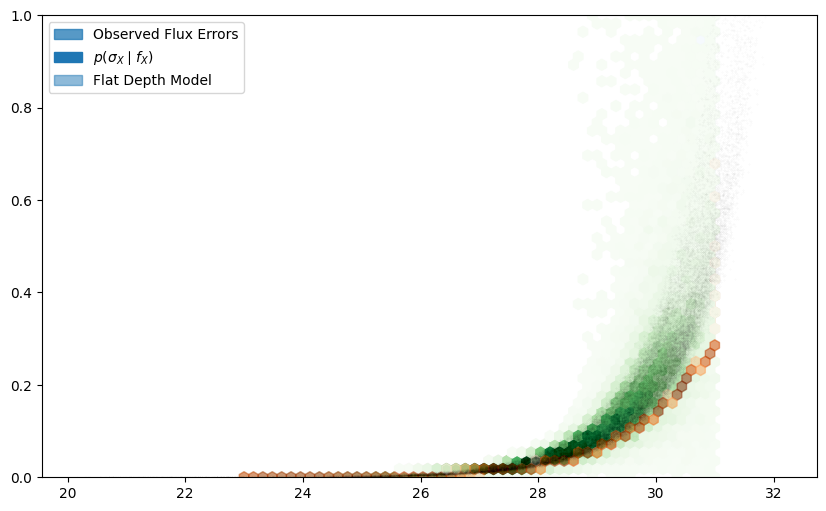

In [198]:
file = '/home/tharvey/Downloads/JADES-Deep-GS_MASTER_Sel-f277W+f356W+f444W_v9_loc_depth_masked_10pc_EAZY_matched_selection_ext_src_UV.fits'


table = Table.read(file)

band = 'f444W'

flux = table[f'MAG_APER_{band}_aper_corr'][:, 0]  
flux_err_l = table[f'MAGERR_APER_{band}_l1_loc_depth'][:, 0]
flux_err_u = table[f'MAGERR_APER_{band}_u1_loc_depth'][:, 0]
# drop NaNs and -99's

mask = (flux != -99) & (flux_err_l != -99) & (flux_err_u != -99) & (flux > 0) & (flux_err_l > 0) & (flux_err_u > 0)
flux = flux[mask]
flux_err_l = flux_err_l[mask]
flux_err_u = flux_err_u[mask]

# bin and plot as contour
plt.figure(figsize=(10, 6))

plt.hexbin(flux, flux_err_l, gridsize=50, cmap='Blues', mincnt=1, extent=(23, 31, 0, 1), alpha=0.75)
plt.hexbin(flux, flux_err_u, gridsize=50, cmap='Reds', mincnt=1, extent=(23, 31, 0, 1), alpha=0.75, label='Observed Flux Errors')
plt.scatter(flux, (flux_err_l + flux_err_u) / 2, alpha=0.03, color='black', s=0.1, zorder=10)
plt.ylim(0, 1)


noise_model = EmpiricalUncertaintyModel(flux, (flux_err_l + flux_err_u) / 2, num_bins=20, log_bins=True)
noisy_flux, sampled_sigma = noise_model.apply_noise_to_flux(flux, max_sigma_deviation=10, true_flux_units='AB')

#plt.scatter(noisy_flux, sampled_sigma, alpha=0.1, color='green', s=0.1)
plt.hexbin(noisy_flux, sampled_sigma, gridsize=50, cmap='Greens', mincnt=1, extent=(23, 31, 0, 1), alpha=1, label=r'$p\left(\sigma_X \mid f_X\right)$')

plt.hexbin(depth_model_fitter.feature_array[:, -21], depth_model_fitter.feature_array[:, -1], mincnt=1,extent=(23, 31, 0, 1), cmap='Oranges', gridsize=50, alpha=0.5, label='Flat Depth Model')

plt.legend()

0.00014334917 3.6776215e-05
5.4985285e-05 1.3073304e-05
6.377697e-05 1.314848e-05
3.7699938e-05 7.721966e-06
3.0100346e-05 6.0780944e-06
3.516674e-05 5.196354e-06
2.771616e-05 8.659331e-06
6.631017e-05 1.9962212e-05
4.976988e-05 1.5929776e-05


(np.float32(20.87883), np.float32(31.764267))

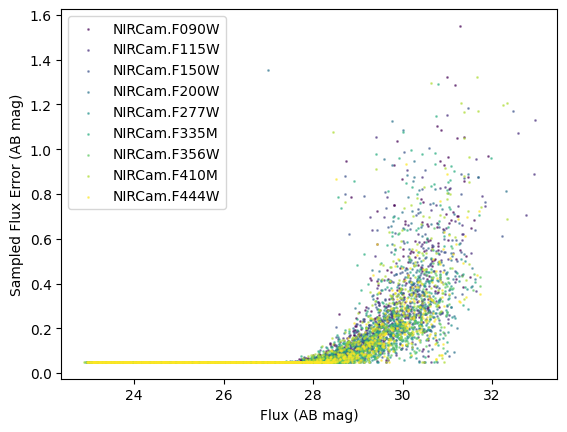

In [265]:
jades_filters = ['f090W', 'f115W', 'f150W', 'f200W', 'f277W', 'f335M', 'f356W', 'f410M', 'f444W']

empirical_noise_models = {}

for filter_name in jades_filters:
    fitter_filter_name = f'NIRCam.{filter_name.upper()}'

    flux = table[f'MAG_APER_{filter_name}_aper_corr'][:, 0]
    flux_err_l = table[f'MAGERR_APER_{filter_name}_l1_loc_depth'][:, 0]
    flux_err_u = table[f'MAGERR_APER_{filter_name}_u1_loc_depth'][:, 0]

    mask = (flux != -99) & (flux_err_l != -99) & (flux_err_u != -99) & (flux_err_l > 0) & (flux_err_u > 0)
    flux = flux[mask]
    flux_err_l = flux_err_l[mask]
    flux_err_u = flux_err_u[mask]

    noise_model = EmpiricalUncertaintyModel(flux, (flux_err_l + flux_err_u) / 2, num_bins=20, log_bins=True, min_flux_error=0.05)

    empirical_noise_models[fitter_filter_name] = noise_model


# Plot median line for all
flux = np.linspace(23, 31, 1000)
colors = plt.cm.viridis(np.linspace(0, 1, len(empirical_noise_models)))
for a, (filter_name, noise_model) in enumerate(empirical_noise_models.items()):
    noisy_flux, sampled_sigma = noise_model.apply_noise_to_flux(flux, true_flux_units='AB')
    plt.scatter(noisy_flux, sampled_sigma, label=f'{filter_name}', alpha=0.5, color=colors[a], s=1)
plt.xlabel('Flux (AB mag)')
plt.ylabel('Sampled Flux Error (AB mag)')

plt.legend()
    
empirical_noise_models['NIRCam.F444W'].get_valid_flux_range()


In [264]:
empirical_model_fitter = SBI_Fitter.init_from_hdf5('Pop_II_LogNormal_SFH_5_z_12_logN_5.0_BPASS_Chab_v1_ensemble_redshift_empirical_noise', 
                                grid_path, return_output=False)

empirical_model_fitter.create_feature_array_from_raw_photometry(extra_features=[], 
                                                                normalize_method=None,
                                                                include_errors_in_feature_array=True,
                                                                scatter_fluxes=4,
                                                                empirical_noise_models=empirical_noise_models,
                                                                photometry_to_remove=[filt for filt in empirical_model_fitter.raw_photometry_names if filt not in list(empirical_noise_models.keys())],
);



Removing 11 photometry filters: ['NIRCam.F070W' 'NIRCam.F140M' 'NIRCam.F162M' 'NIRCam.F182M'
 'NIRCam.F210M' 'NIRCam.F250M' 'NIRCam.F300M' 'NIRCam.F360M'
 'NIRCam.F430M' 'NIRCam.F460M' 'NIRCam.F480M']
Using empirical noise models with 4 scatters per row.
---------------------------------------------
Features: 18 features over 400000 samples
---------------------------------------------
Feature: Min - Max
---------------------------------------------
NIRCam.F090W: 19.758799 - 50.000 AB
NIRCam.F115W: 19.532939 - 50.000 AB
NIRCam.F150W: 19.665573 - 46.268 AB
NIRCam.F200W: 19.374652 - 44.770 AB
NIRCam.F277W: 19.418948 - 43.261 AB
NIRCam.F335M: 18.688372 - 44.493 AB
NIRCam.F356W: 19.161545 - 43.352 AB
NIRCam.F410M: 19.350325 - 43.715 AB
NIRCam.F444W: 19.162421 - 43.983 AB
unc_NIRCam.F090W: 0.050000 - 3.927 AB
unc_NIRCam.F115W: 0.050000 - 3.877 AB
unc_NIRCam.F150W: 0.050000 - 3.476 AB
unc_NIRCam.F200W: 0.050000 - 3.324 AB
unc_NIRCam.F277W: 0.050000 - 2.928 AB
unc_NIRCam.F335M: 0.050000 - 3.5

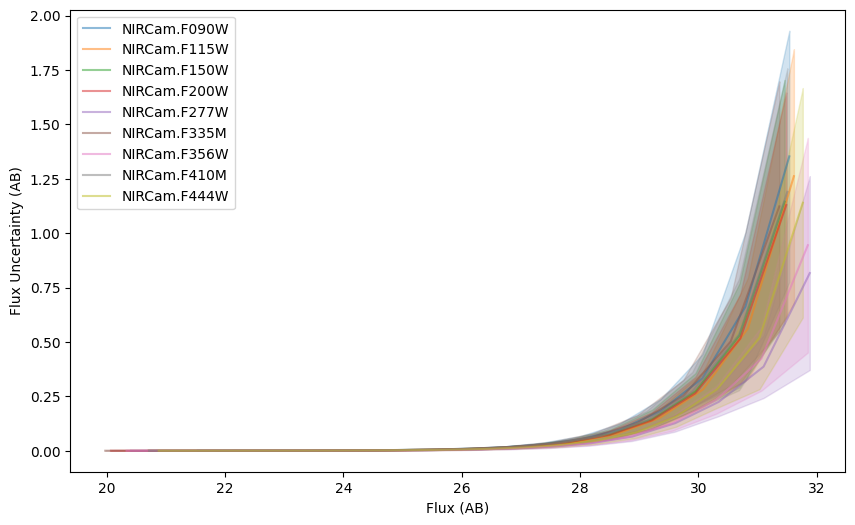

In [196]:
fig, ax = plt.subplots(figsize=(10, 6))
for pos, (name, noise_model) in enumerate(empirical_noise_models.items()):
    noise_model.plot_sigma(ax=ax, label=name, alpha=0.5)

ax.legend()


In [266]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([6, 7, 8, 9, 10])

c = np.concatenate((a, b))

c

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [277]:
from synthesizer.emission_models.dust.emission import IR_templates
from synthesizer.grid import Grid
from synthesizer.parametric import SFH, ZDist

path = '/home/tharvey/work/synthesizer_grids'

dl07_grid = Grid('draine_li_dust_emission_grid_MW_3p1', grid_dir=path, read_lines=False)


In [280]:
from unyt import Msun, Angstrom

lam = 10 ** (np.arange(3.0, 8.0, 0.01)) 
lam = lam * Angstrom  # Convert to Angstroms

for mdust in [1e7, 1e8, 5e8, 1e9, 5e9]:
    model = IR_templates(
        dl07_grid, mdust=mdust * Msun, verbose=False
    )
    sed = model.get_spectra(lam)

    # Normalise the SED to the bolometric luminosity
    sed._lnu /= sed._bolometric_luminosity

    # And plot...
    plt.loglog(
        sed.lam,
        sed.luminosity,
        label="{:.1e} Msun, <U>={:.2f}".format(mdust, model.u_avg),
    )
    plt.title("Draine & Li 2007")

plt.xlabel(r"$ \lambda / \AA$")
plt.ylabel(r"$ L_{\nu} / L_{bol}$")
plt.ylim(10**-3, 1)
plt.legend()
plt.show()

InvalidUnitOperation: Tried to multiply a Unit object with 'None' (type <class 'NoneType'>). This behavior is undefined.